In [9]:
import numpy as np
import pandas as pd
from MVA_algo import *
from AnchorOptimalProjector import *
from sklearn.linear_model import LinearRegression, RidgeCV, MultiTaskLassoCV
from tqdm import tqdm
from matplotlib import pyplot as plt
from itertools import permutations
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, r2_score
import torch
from IRM_ICP import InvariantRiskMinimization, InvariantCausalPrediction
from IRM import IRMLinearRegression, IRMLinearRegression2
from CVP import CVPLinearRegression, CVPLinearRegression2
from sklearn.cross_decomposition import PLSRegression
from HRM import HRMLinearRegression

In [2]:
data = pd.read_csv('../data/Air_Quality.csv')

In [3]:
data_cleaned = data.loc[:, ~data.columns.str.contains('^Unnamed')][:9357]
data_cleaned['Date'] = pd.to_datetime(data_cleaned['Date'], format='%d/%m/%Y')

# Define a function to map month to season
def get_season(month):
    if month in [12, 1, 2]:
        return 0  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    elif month in [9, 10, 11]:
        return 3  # Autumn

# Apply the function to extract the season
data_cleaned['Season'] = data_cleaned['Date'].dt.month.map(get_season)

In [4]:
Y = data_cleaned[['CO(GT)',	'PT08.S1(CO)',	'NMHC(GT)',	'C6H6(GT)',	'PT08.S2(NMHC)',	'NOx(GT)',	'PT08.S3(NOx)',	'NO2(GT)',	'PT08.S4(NO2)',	'PT08.S5(O3)']].to_numpy()
A = data_cleaned['Season'].to_numpy()[:, None]
X = data_cleaned[['T', 'RH', 'AH']].to_numpy()

In [5]:
Y = (Y - Y.mean(axis=0))/Y.std(axis=0)
X = (X - X.mean(axis=0))/X.std(axis=0)

In [6]:
idx_train = (A==0)[:, 0]
idx_val = ((A==3) | (A==1))[:, 0]
idx_test = (A==2)[:, 0]
X_train, X_test, X_val = X[idx_train, :], X[idx_test.T, :], X[idx_val, :]
A_train, A_test, A_val = A[idx_train, :], A[idx_test.T, :], A[idx_val, :]
Y_train, Y_test, Y_val = Y[idx_train, :], Y[idx_test.T, :], Y[idx_val, :]

In [10]:
gammas = np.logspace(-10, 10, 10)
lambdas = np.logspace(-3, 3, 10)
thetas = np.logspace(-3, 3, 10)
alphas = np.logspace(-10, 10, 10)
deltas = np.logspace(-10, 10, 10)
patience = 200
n_epochs = 50000
learning_rate = 0.03
n_components = [1, 2, 3]
score, score_ar, score_irm, score_hrm, score_cvp, score_pls_ar, score_ridge = [], [], [], [], [], [], []
seasons = np.array([0, 1, 2, 3])
combinations = list(permutations(seasons, 3))  # All train-val-test splits
lr = LinearRegression()
for train_season, val_season, test_season in tqdm(combinations):
    idx = [i not in list(permutations([0,1,2, 3], 3))[0] for i in np.array([0,1,2, 3])]
    val_season2 = seasons[idx]
    idx_train = (A==train_season | (A==val_season2))[:, 0]
    idx_val = (A==val_season)[:, 0]
    idx_test = (A==test_season)[:, 0]
    X_train, X_test, X_val = X[idx_train, :], X[idx_test.T, :], X[idx_val, :]
    A_train, A_test, A_val = A[idx_train, :], A[idx_test.T, :], A[idx_val, :]
    Y_train, Y_test, Y_val = Y[idx_train, :], Y[idx_test.T, :], Y[idx_val, :]

    # Selecting gamma opt
    
    mse_scores_ar = []
    for gamma in gammas:
        aop = AnchorOptimalProjection(gamma=gamma)
        X_anchor, Y_anchor = aop.fit_transform(A_train, X_train, Y_train)
        lr.fit(X_anchor, Y_anchor)
        Y_pred = lr.predict(X_val)
        mse_scores_ar.append(mean_squared_error(Y_val, Y_pred))
    gamma_opt = gammas[np.argmin(mse_scores_ar)]

    # gamma and ncp opt
    mse_scores_pls_ar = []
    for gamma in gammas:
        mse_scores_for_gamma = []
        for ncp in n_components:
            aop = AnchorOptimalProjection(gamma=gamma)
            X_anchor, Y_anchor = aop.fit_transform(A_train, X_train, Y_train)
            pls = PLSRegression(n_components=ncp)
            pls.fit(X_anchor, Y_anchor)
            Y_pred = pls.predict(X_val)
            mse = mean_squared_error(Y_val, Y_pred)
            mse_scores_for_gamma.append(mse)
        mse_scores_pls_ar.append(mse_scores_for_gamma)
    mse_scores_pls_ar = np.array(mse_scores_pls_ar)
    best_gamma_idx, best_ncp_idx = np.unravel_index(np.argmin(mse_scores_pls_ar), mse_scores_pls_ar.shape)
    gamma_opt_pls = gammas[best_gamma_idx]
    ncp_opt = n_components[best_ncp_idx]

    # alpha opt ridge
    mse_scores_ridge = []
    for alpha in alphas:
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train, Y_train)
        Y_pred = ridge.predict(X_val)
        mse_scores_ridge.append(mean_squared_error(Y_val, Y_pred))
    alpha_opt = alphas[np.argmin(mse_scores_ridge)]


    #  Selecting lambda opt for IRM
    input_dim = X_train.shape[1]
    output_dim = Y_train.shape[1]
    mse_scores_irm = []
    for l in lambdas:
        irm_model = IRMLinearRegression2(input_dim, output_dim, lambda_irm=l, n_epochs=n_epochs, learning_rate=learning_rate, patience=patience, tol=1e-4, verbose=False)
        irm_model.fit(X_train, Y_train, A_train[:, 0])
        Y_pred = irm_model.predict(X_val)
        mse_scores_irm.append(mean_squared_error(Y_val, Y_val))
    lambda_opt = lambdas[np.argmin(mse_scores_irm)]

    # selecting theta opt for CVP
    mse_scores_cvp = []
    for theta in thetas:
        cvp_model = CVPLinearRegression(input_dim, output_dim, lambda_cvp=theta, n_epochs=n_epochs, learning_rate=learning_rate, patience=patience, tol=1e-4, verbose=False)
        cvp_model.fit(X_train, Y_train, A_train[:, 0])
        sklearn_model = cvp_model.set_sklearn_model()
        Y_pred = sklearn_model.predict(X_val)
        mse_scores_cvp.append(mean_squared_error(Y_val, Y_val))
    theta_opt = thetas[np.argmin(mse_scores_cvp)]

    # selecting delta opt for HRM
    # mse_scores_hrm = []
    # for delta in deltas:
    #     hrm_model = HRMLinearRegression(input_dim, output_dim, lambda_hrm=delta, n_epochs=n_epochs, learning_rate=learning_rate, patience=patience, tol=1e-4, verbose=False)
    #     cvp_model.fit(X_train, Y_train, A_train[:, 0])
    #     Y_pred = hrm_model.predict(X_val)
    #     mse_scores_hrm.append(mean_squared_error(Y_val, Y_val))
    # delta_opt = deltas[np.argmin(mse_scores_hrm)]
    
    # Train test split
    # idx_train = ((A==train_season) | (A==val_season2) | (A==val_season))[:, 0]
    # X_train, X_test = X[idx_train, :], X[idx_test.T, :]
    # A_train, A_test = A[idx_train, :], A[idx_test.T, :]
    # Y_train, Y_test = Y[idx_train, :], Y[idx_test.T, :]

    # optimal anchor regression
    aop = AnchorOptimalProjection(gamma=gamma_opt)
    X_anchor, Y_anchor = aop.fit_transform(A_train, X_train, Y_train)
    lr.fit(X_anchor, Y_anchor)
    Y_pred = lr.predict(X_test)
    score_ar.append(mean_squared_error(Y_test, Y_pred))

    # optimal anchor PLS
    aop = AnchorOptimalProjection(gamma=gamma_opt_pls)
    X_anchor, Y_anchor = aop.fit_transform(A_train, X_train, Y_train)
    pls = PLSRegression(n_components=ncp_opt)
    pls.fit(X_anchor, Y_anchor)
    Y_pred = pls.predict(X_test)
    score_pls_ar.append(mean_squared_error(Y_test, Y_pred))

    # optimal IRM regression
    irm_model = IRMLinearRegression2(input_dim, output_dim, lambda_irm=lambda_opt, n_epochs=n_epochs, learning_rate=learning_rate, patience=patience, tol=1e-4, verbose=False)
    irm_model.fit(X_train, Y_train, A_train[:, 0])
    Y_pred = irm_model.predict(X_test)
    score_irm.append(mean_squared_error(Y_test, Y_pred))

    # optimal HRM regression
    hrm_model = HRMLinearRegression(input_dim, output_dim, lambda_hrm=delta_opt, n_epochs=n_epochs, learning_rate=learning_rate, patience=patience, tol=1e-4, verbose=False)
    hrm_model.fit(X_train, Y_train, A_train[:, 0])
    Y_pred = hrm_model.predict(X_test)
    score_hrm.append(mean_squared_error(Y_test, Y_pred))

    # optimal CVP regression
    cvp_model = CVPLinearRegression(input_dim, output_dim, lambda_cvp=theta_opt, n_epochs=n_epochs, learning_rate=learning_rate, patience=patience, tol=1e-4, verbose=False)
    cvp_model.fit(X_train, Y_train, A_train[:, 0])
    sklearn_model = cvp_model.set_sklearn_model()
    Y_pred = sklearn_model.predict(X_test)
    score_cvp.append(mean_squared_error(Y_test, Y_pred))

    lr.fit(X_train, Y_train)
    Y_pred = lr.predict(X_test)
    score.append(mean_squared_error(Y_test, Y_pred))

    ridge = Ridge(alpha=alpha_opt)
    ridge.fit(X_train, Y_train)
    Y_pred = ridge.predict(X_test)
    score_ridge.append(mean_squared_error(Y_test, Y_pred))
    
    

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:18<?, ?it/s]


TypeError: expected Tensor as element 1 in argument 0, but got numpy.ndarray

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


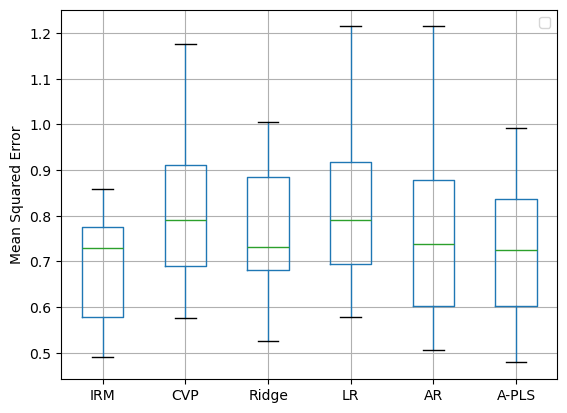

In [ ]:
df = pd.DataFrame(np.array([score_irm, score_cvp, score_ridge, score, score_ar, score_pls_ar]).T, columns=['IRM', 'CVP', 'Ridge', 'LR', 'AR', 'A-PLS'])
df.boxplot()
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [ ]:
# Initialize result dictionary
result = {}

# Reference column for comparison
reference_column = 'LR'

# Determine the algorithm performing best in each row
best_counts = (df.eq(df.min(axis=1), axis=0)).sum()

# Calculate statistics and comparison
for algorithm in df.columns:
    mean_mse = df[algorithm].mean()
    median_mse = df[algorithm].median()
    max_mse = df[algorithm].max()
    min_mse = df[algorithm].min()
    better_than_lr = (df[algorithm] < df[reference_column]).sum()
    best_performance = best_counts[algorithm]

    result[algorithm] = {
        'Mean MSE': mean_mse,
        'Median MSE': median_mse,
        'Max MSE': max_mse,
        'Min MSE': min_mse,
        'Better than LR': better_than_lr    }

# Convert result dictionary to a DataFrame
result_df = pd.DataFrame(result).T

# Convert to markdown
markdown_table = result_df.to_markdown()

print(markdown_table)

|       |   Mean MSE |   Median MSE |   Max MSE |   Min MSE |   Better than LR |
|:------|-----------:|-------------:|----------:|----------:|-----------------:|
| IRM   |   0.686253 |     0.728511 |  0.857703 |  0.489722 |               20 |
| CVP   |   0.814105 |     0.79024  |  1.17661  |  0.576044 |               21 |
| Ridge |   0.767386 |     0.730688 |  1.006    |  0.526444 |               18 |
| LR    |   0.821291 |     0.791441 |  1.21461  |  0.578454 |                0 |
| AR    |   0.778622 |     0.738854 |  1.21461  |  0.505814 |               16 |
| A-PLS |   0.722477 |     0.725128 |  0.993102 |  0.478632 |               22 |
